In [11]:
import numpy as np
from vectorize import load_json, save_json,vectorize,generate_sim_matrix
from pullDescriptions import getDesc
import scipy.cluster.hierarchy as hc
from sklearn.manifold import MDS
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from cluster_comparison import compare
from jaccardSimilarity import jaccardStringSimilarity
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA
import nltk
from sklearn.metrics import f1_score
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans
%cd ./NCDBasedChecker
from NCDBasedChecker import utils
from NCDClusterer import Clusterer
%cd ..

c:\Users\vikram14\Desktop\Research\IntelliDiff\NCDBasedChecker
c:\Users\vikram14\Desktop\Research\IntelliDiff


## Set-Up

In [3]:
manuals= load_json('./comp116/116Q2Solns_Manual_Labeled_With_Rare_new.json')
manuals =[{'studentID':k, 'code':v['solution'], 'label_order1': v['label_order1'], 'description':""}for k,v in manuals.items()]

In [4]:
#getDesc(methods,'comp116/116Q2Solns-descriptions')
data = load_json('./comp116/116Q2Soln-desc')
methods = [{'studentID':k, 'code':v['solution'], 'label':"", 'description':v['description']}for k,v in data.items()]
#save_json(methods, './comp116/116Q2Soln-desc-list')


## 1) Jaccardian for similarity

#### Compute Similarity Matrix using Jaccard distance between descriptions.

In [29]:
def generateSimMat_jaccard_distance():
    sim_mat=np.zeros((len(methods),len(methods)),dtype=np.float64)
    for i in range(sim_mat.shape[0]):
        for j in range (i+1,sim_mat.shape[0]):
            sim=jaccardStringSimilarity(methods[i]['description'],methods[j]['description'])
            sim_mat[i,j]=sim
            sim_mat[j,i]=sim
    return sim_mat
sim_mat_jaccard=generateSimMat_jaccard_distance()

#### Visualize Vectors and Manual labels

In [30]:
y=np.array([manual['label_order1'] for manual in manuals])

In [31]:
cmap={'1':'red','2':'blue','3':'green','4':'yellow'}
jaccard_vectors_2dim = MDS(n_components= 2, dissimilarity='precomputed',max_iter=10000).fit_transform(sim_mat_jaccard)

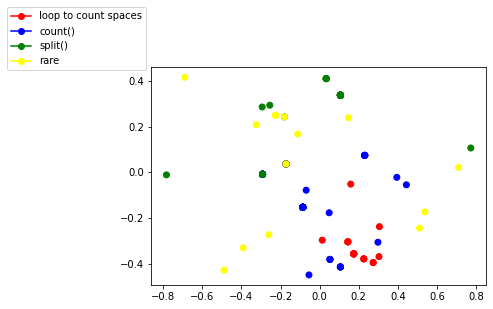

In [32]:
fig, ax = plt.subplots()
ax.scatter(jaccard_vectors_2dim[:,0],jaccard_vectors_2dim[:,1], c=[cmap[i] for i in y])
custom_legend=(Line2D([0],[0], marker ='o',color='red'),Line2D([0],[0], marker ='o',color='blue'),Line2D([0],[0], marker ='o',color='green'),Line2D([0],[0], marker ='o',color='yellow'))
ax.legend(custom_legend,["loop to count spaces","count()","split()","rare"],bbox_to_anchor =(0,1.3))

# for i in range(jaccard_vectors_2dim.shape[0]):
#     ax.annotate(methods[i]['studentID'][7:], (jaccard_vectors_2dim[i,0],jaccard_vectors_2dim[i,1]))

#### K-Means

In [34]:
kmeans = KMeans(n_clusters=4,max_iter=10000)
kmeans.fit(jaccard_openai_vectors)
labels_med = kmeans.labels_

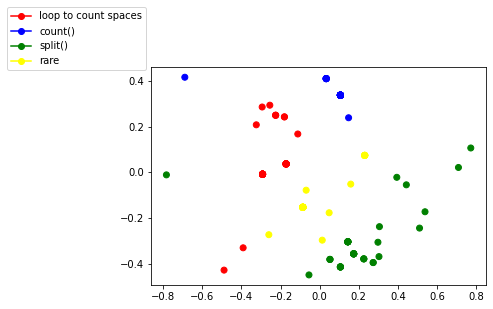

In [35]:

cmap1={'2':'red','0':'blue','3':'green','1':'yellow'}
fig, ax = plt.subplots()
ax.scatter(jaccard_vectors_2dim[:,0],jaccard_vectors_2dim[:,1], c=[cmap1[str(i)] for i in labels_med])
ax.legend(custom_legend,["loop to count spaces","count()","split()","rare"],bbox_to_anchor =(0,1.3))

In [36]:
clusters={i:[] for i in labels_med} #if i>0}
sims={i:[] for i in labels_med}
for i,m in enumerate(methods):
    # if(labels[i]<=0):
    #     continue
    clusters[labels_med[i]].append((m['code'],m['description'],m['studentID']))
    sims[labels_med[i]].append(i)



for k,v in clusters.items():
    print(f"GROUP : {k} SIZE : {len(v)}")
    print()    
    for m in v:
        print(f'{m[2]}')
        print('-'+'\n-'.join(nltk.sent_tokenize(m[1])))
        print(m[0])
        print("\n ######")
    print("\n***********************************************")

GROUP : 3 SIZE : 41

student085
-it is counting the number of words in the string.It is doing this by counting the number of spaces in the string and adding 1 to that count.
# cell 6 of 14

def word_count(temp_text):
    '''Return the number of words'''
    num_words = 1
    for x in temp_text: 
        if x == ' ':
            num_words += 1
    # num_words: the number of words in the string temp_text
    return num_words

 ######
student099
-it is counting the number of words in the string.It is doing this by adding 1 to the number of spaces in the string.
# cell 6 of 14

def word_count(temp_text):
    '''Return the number of words'''
    # num_words: the number of words in the string temp_text
    num_words = 1 + (temp_text.count(' '))
    return num_words

 ######
student033
-it is counting the number of words in the string.It is doing this by counting the number of punctuation marks and adding them to a new string.Then it counts the length of that string and returns it as the numb

#### SVM Classification

In [12]:
jaccard_openai_vectors = MDS(n_components= 24, dissimilarity='precomputed').fit_transform(sim_mat_jaccard)

In [66]:
X_train,X_test, y_train, y_test = train_test_split(jaccard_openai_vectors,y,test_size=0.30, random_state=1)

In [67]:
svc = SVC(kernel='linear')

In [68]:
fitted_model = svc.fit(X_train,y_train)
predicted_y= fitted_model.predict(jaccard_openai_vectors)

#####  Confusion Matrix for Test Set

accuracy on test set: 0.7647058823529411
f1 score : 0.677744971862619


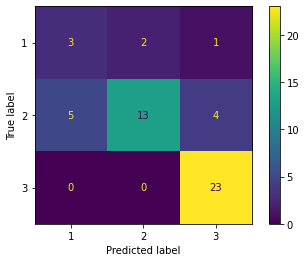

In [69]:
print(f'accuracy on test set: {fitted_model.score(X_test,y_test)}')
print(f"f1 score : {f1_score(y_test, fitted_model.predict(X_test),average='macro')}")
cfd=ConfusionMatrixDisplay.from_estimator(fitted_model,X_test,y_test)

##### Confusion Matrix for All Submissions

accuracy on all submissions: 0.7857142857142857
f1 score : 0.752260348583878


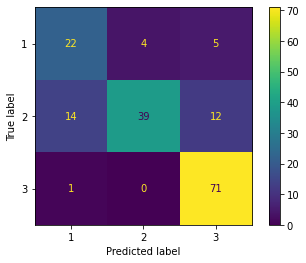

In [70]:
print(f'accuracy on all submissions: {fitted_model.score(jaccard_openai_vectors,y)}')
print(f"f1 score : {f1_score(y, predicted_y,average='macro')}")
cfd=ConfusionMatrixDisplay.from_estimator(fitted_model,jaccard_openai_vectors,y)

##### Misclassified

In [106]:
for idx,v in enumerate(y):
    if(v!=predicted_y[idx]):
        print(predicted_y[idx],v)
        print(methods[idx])

2 1
{'studentID': 'student085', 'code': "# cell 6 of 14\n\ndef word_count(temp_text):\n    '''Return the number of words'''\n    num_words = 1\n    for x in temp_text: \n        if x == ' ':\n            num_words += 1\n    # num_words: the number of words in the string temp_text\n    return num_words", 'label': '', 'description': 'it is counting the number of words in the string.It is doing this by counting the number of spaces in the string and adding 1 to that count.'}
2 1
{'studentID': 'student033', 'code': '# cell 6 of 14\n\ndef word_count(temp_text):\n    num_words = ""\n    for words in temp_text:\n        if words.lower() == "." or words.lower() == "!" or words.lower() == ";" or words.lower() == ":" or words.lower() == "?" or words.lower() == " ":\n            num_words += words\n    \'\'\'Return the number of words\'\'\'\n    # num_words: the number of words in the string temp_text\n    return len(num_words)', 'label': '', 'description': 'it is counting the number of words in 

#### Unsupervised Hierarchical Clustering

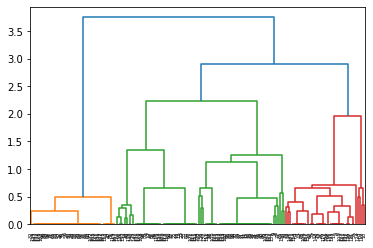

In [72]:
clusterer = Clusterer(sim_mat_jaccard)
linkage=clusterer.cluster(clusteringLikage='ward',sigmoid=False)
_=utils.plot_dendrogram(linkage,0,None)

In [73]:
labels=hc.fcluster(linkage,t=3,criterion='maxclust')

In [74]:
clusters={i:[] for i in labels}
for i,m in enumerate(methods):
    clusters[labels[i]].append((m['code'],m['description']))

for k,v in clusters.items():
    print(f"GROUP : {k} SIZE : {len(v)}")
    print()    
    for m in v:
        print('-'+'\n-'.join(nltk.sent_tokenize(m[1])))
        print(m[0])
        print("\n ######")
    print("\n***********************************************")

GROUP : 3 SIZE : 40

-it is counting the number of words in the string.It is doing this by counting the number of spaces in the string and adding 1 to that count.
# cell 6 of 14

def word_count(temp_text):
    '''Return the number of words'''
    num_words = 1
    for x in temp_text: 
        if x == ' ':
            num_words += 1
    # num_words: the number of words in the string temp_text
    return num_words

 ######
-it is counting the number of words in the string.It is doing this by adding 1 to the number of spaces in the string.
# cell 6 of 14

def word_count(temp_text):
    '''Return the number of words'''
    # num_words: the number of words in the string temp_text
    num_words = 1 + (temp_text.count(' '))
    return num_words

 ######
-it is counting the number of words in the string.It is doing this by counting the number of punctuation marks and adding them to a new string.Then it counts the length of that string and returns it as the number of words.
# cell 6 of 14

def 

##### Unsupervised Clustering Comparison to Manual Labels

*********************************

iou:{('2', '1'): 0.4222222222222222, ('1', '4'): 0.24561403508771928, ('3', '3'): 0.5873015873015873, ('0', '2'): 0.578125}


accuracy:{('2', '1'): 0.8260869565217391, ('1', '4'): 0.5, ('3', '3'): 0.6607142857142857, ('0', '2'): 0.6065573770491803}

rand score: 0.7405189620758483
adjusted rand score: 0.336079601504632
normalized mutual information: 0.3891318866800656
fowlkes mallows score: 0.5128189996121909
confusion matrix:
    (0,0) - True Negatives. Pair is not clustered together in the predicted and manual clustering.
    (0,1) - False Positives. Pair is clustered together in prediction but not manual clustering.
    (1,0) - False Negatives. Pair is not clustered together in prediction but is clustered together in manual clustering.
    (1,1) - True Positives.  Pair is clustered together in the predicted and manual clustering.



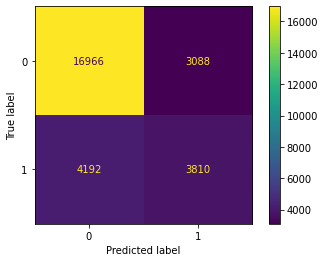

In [25]:
file_path_manual= './comp116/116Q2Solns_Manual_Labeled_With_Rare_new.json'
file_path_openai_jaccard='./comp116/116Q2Soln-OPENAI-Jaccard-4clust.json'
cfd=compare(file_path_openai_jaccard, file_path_manual).plot()

## 2) Vector representation for descriptions for similarity

#### Generate vectors

In [76]:
# for m in methods:
#     differ.getSentences(m['description'])
description_openai_vectors=vectorize(path='./comp116/116Q2Soln-desc-list')

1/168
101/168


#### Visualize vectors and manual labels

In [78]:
pca=PCA(n_components=2)
description_openai_vectors_2dim=pca.fit_transform(description_openai_vectors)

In [79]:
y=np.array([manual['label_order1'] for manual in manuals])

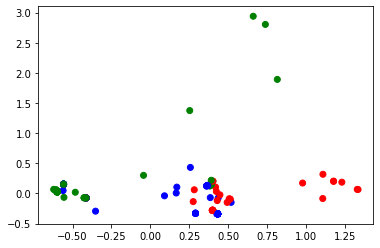

In [80]:
fig, ax = plt.subplots()
ax.scatter(description_openai_vectors_2dim[:,0],description_openai_vectors_2dim[:,1], c=[cmap[i] for i in y])

# for i in range(description_openai_vectors_2dim.shape[0]):
#     ax.annotate(methods[i]['studentID'][7:], (description_openai_vectors_2dim[i,0],description_openai_vectors_2dim[i,1]))

#### SVM Classification

In [81]:
X_train,X_test, y_train, y_test = train_test_split(description_openai_vectors,y,test_size=0.30, random_state=1)

In [82]:
svc = SVC(kernel='linear')

In [83]:
fitted_model = svc.fit(X_train,y_train)
predicted_y= fitted_model.predict(description_openai_vectors)

#####  Confusion Matrix for Test Set

accuracy on test set: 0.8627450980392157
f1 score : 0.8264111705288175


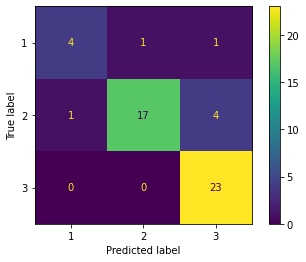

In [84]:
print(f'accuracy on test set: {fitted_model.score(X_test,y_test)}')
print(f"f1 score : {f1_score(y_test, fitted_model.predict(X_test),average='macro')}")
cfd=ConfusionMatrixDisplay.from_estimator(fitted_model,X_test,y_test)

##### Confusion Matrix for All Submissions

accuracy on all submissions: 0.8690476190476191
f1 score : 0.8583479446717318


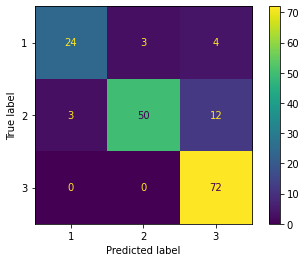

In [85]:
print(f'accuracy on all submissions: {fitted_model.score(description_openai_vectors,y)}')
print(f"f1 score : {f1_score(y, predicted_y,average='macro')}")
cfd=ConfusionMatrixDisplay.from_estimator(fitted_model,description_openai_vectors,y)

##### Misclassified

In [86]:
for idx,v in enumerate(y):
    if(v!=predicted_y[idx]):
        print(predicted_y[idx],v)
        print(methods[idx])

1 2
{'studentID': 'student099', 'code': "# cell 6 of 14\n\ndef word_count(temp_text):\n    '''Return the number of words'''\n    # num_words: the number of words in the string temp_text\n    num_words = 1 + (temp_text.count(' '))\n    return num_words", 'label': '', 'description': 'it is counting the number of words in the string.It is doing this by adding 1 to the number of spaces in the string.'}
1 2
{'studentID': 'student086', 'code': "# cell 6 of 14\n\ndef word_count(temp_text):\n    '''Return the number of words'''\n    # num_words: the number of words in the string temp_text\n    num_words = 0 \n    num_words = temp_text.count(' ')\n    num_words += 1\n    return num_words", 'label': '', 'description': 'it is counting the number of words in the string.It is doing this by counting the number of spaces and adding 1 to that count.'}
3 2
{'studentID': 'student177', 'code': "# cell 6 of 14 - TRIAL\n\ndef word_count(temp_text):\n    '''Return the number of words'''\n    # num_words: th

#### Unsupervised Hierarchical Clustering

In [87]:
def generateSimMat_description(vectors):
    sim_mat=np.zeros((vectors.shape[0],vectors.shape[0]),dtype=np.float64)
    def euclideanDistance(x,y):
        return np.sqrt(np.sum(np.square(x-y)))
    for i in range(vectors.shape[0]):
        for j in range (i+1,vectors.shape[0]):
            sim=euclideanDistance(vectors[i,:],vectors[j,:])
            sim_mat[i,j]=sim
            sim_mat[j,i]=sim
    return (sim_mat-np.min(sim_mat))/(np.max(sim_mat)-np.min(sim_mat))
sim_mat_desc= generateSimMat_description(description_openai_vectors)

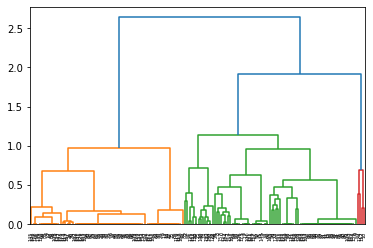

In [88]:
clusterer = Clusterer(sim_mat_desc)
linkage=clusterer.cluster(clusteringLikage='ward',sigmoid=False)
_=utils.plot_dendrogram(linkage,0,None)

In [89]:
labels=hc.fcluster(linkage,t=3,criterion='maxclust')

In [90]:
clusters={i:[] for i in labels}
for i,m in enumerate(methods):
    clusters[labels[i]].append((m['code'],m['description']))

for k,v in clusters.items():
    print(f"GROUP : {k} SIZE : {len(v)}")
    print()    
    for m in v:
        print('-'+'\n-'.join(nltk.sent_tokenize(m[1])))
        print(m[0])
        print("\n ######")
    print("\n***********************************************")

GROUP : 2 SIZE : 87

-it is counting the number of words in the string.It is doing this by counting the number of spaces in the string and adding 1 to that count.
# cell 6 of 14

def word_count(temp_text):
    '''Return the number of words'''
    num_words = 1
    for x in temp_text: 
        if x == ' ':
            num_words += 1
    # num_words: the number of words in the string temp_text
    return num_words

 ######
-it is counting the number of words in the string.It is doing this by adding 1 to the number of spaces in the string.
# cell 6 of 14

def word_count(temp_text):
    '''Return the number of words'''
    # num_words: the number of words in the string temp_text
    num_words = 1 + (temp_text.count(' '))
    return num_words

 ######
-it is counting the number of words in the string.It is doing this by counting the number of punctuation marks and adding them to a new string.Then it counts the length of that string and returns it as the number of words.
# cell 6 of 14

def 

##### Unsupervised Clustering Comparison to Manual Labels

*********************************

iou:{('2', '2'): 0.52, ('1', '3'): 0.7126436781609196, ('3', '3'): 0.05555555555555555}


accuracy:{('2', '2'): 0.8, ('1', '3'): 0.8611111111111112, ('3', '3'): 0.05555555555555555}

rand score: 0.6914741944682065
adjusted rand score: 0.37465644215418126
normalized mutual information: 0.3681953791308779
fowlkes mallows score: 0.6381236079462891
confusion matrix:
    (0,0) - True Negatives. Pair is not clustered together in the predicted and manual clustering.
    (0,1) - False Positives. Pair is clustered together in prediction but not manual clustering.
    (1,0) - False Negatives. Pair is not clustered together in prediction but is clustered together in manual clustering.
    (1,1) - True Positives.  Pair is clustered together in the predicted and manual clustering.



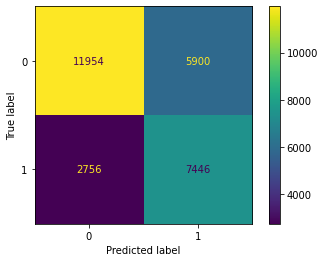

In [91]:
file_path_openai_descVectors='./comp116/116Q2Soln-OPENAI-Descvector-3clust.json'
cfd=compare(file_path_openai_descVectors,file_path_manual).plot()

## 3) Maximum Mean euclidean distance between Sentence vectors of descriptions between pairs as similarity metric

#### Generate Similarity Matrix

In [40]:
sim_mat_sentence = generate_sim_matrix(path='./comp116/116Q2Soln-desc-list')

1/168
101/168


#### Visualize vectors and manual labels

In [41]:
y=np.array([manual['label_order1'] for manual in manuals])

In [44]:
cmap={'1':'red','2':'blue','3':'green','4':'yellow'}
sentence_vectors_2dim = MDS(n_components= 2, dissimilarity='precomputed',max_iter=10000).fit_transform(sim_mat_sentence)

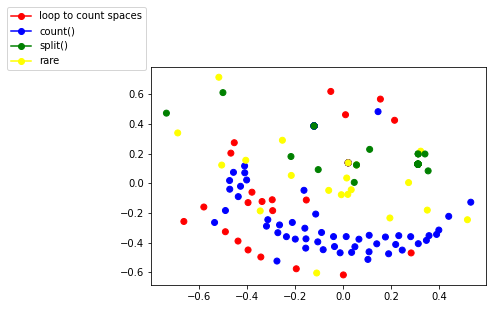

In [45]:
fig, ax = plt.subplots()
ax.scatter(sentence_vectors_2dim[:,0],sentence_vectors_2dim[:,1], c=[cmap[i] for i in y])
custom_legend=(Line2D([0],[0], marker ='o',color='red'),Line2D([0],[0], marker ='o',color='blue'),Line2D([0],[0], marker ='o',color='green'),Line2D([0],[0], marker ='o',color='yellow'))
ax.legend(custom_legend,["loop to count spaces","count()","split()","rare"],bbox_to_anchor =(0,1.3))
# for i in range(sentence_vectors_2dim.shape[0]):
#     ax.annotate(methods[i]['studentID'][7:], (sentence_vectors_2dim[i,0],sentence_vectors_2dim[i,1]))

#### K-MEANS

In [79]:
# kmeans = KMeans(n_clusters=4,max_iter=10000)
# kmeans.fit(sentence_openai_vectors)
# labels_med = kmeans.labels_
from sklearn.mixture import GaussianMixture
labels_med = GaussianMixture(n_components=4, random_state=0).fit_predict(sentence_openai_vectors)

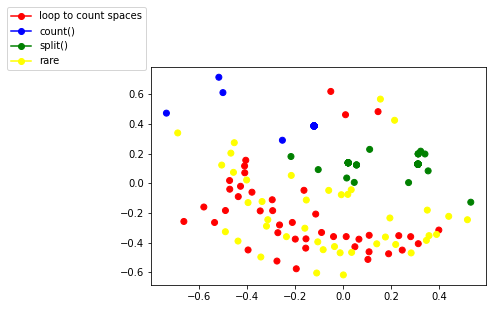

In [84]:
cmap1={'3':'red','0':'blue','1':'green','2':'yellow'}
fig, ax = plt.subplots()
ax.scatter(sentence_vectors_2dim[:,0],sentence_vectors_2dim[:,1], c=[cmap1[str(i)] for i in labels_med])
ax.legend(custom_legend,["loop to count spaces","count()","split()","rare"],bbox_to_anchor =(0,1.3))

In [ ]:
clusters={i:[] for i in labels_med} #if i>0}
sims={i:[] for i in labels_med}
for i,m in enumerate(methods):
    # if(labels[i]<=0):
    #     continue
    clusters[labels_med[i]].append((m['code'],m['description'],m['studentID']))
    sims[labels_med[i]].append(i)



for k,v in clusters.items():
    print(f"GROUP : {k} SIZE : {len(v)}")
    print()    
    for m in v:
        print(f'{m[2]}')
        print('-'+'\n-'.join(nltk.sent_tokenize(m[1])))
        print(m[0])
        print("\n ######")
    print("\n***********************************************")

#### SVM Classification

In [46]:
sentence_openai_vectors = MDS(n_components= 30, dissimilarity='precomputed').fit_transform(sim_mat_sentence)

In [97]:
X_train,X_test, y_train, y_test = train_test_split(sentence_openai_vectors,y,test_size=0.30, random_state=1)

In [45]:
svc = SVC(kernel='rbf')

In [98]:
fitted_model = svc.fit(X_train,y_train)
predicted_y= fitted_model.predict(sentence_openai_vectors)

#####  Confusion Matrix for Test Set

accuracy on test set: 0.8235294117647058
f1 score : 0.6686189627366098


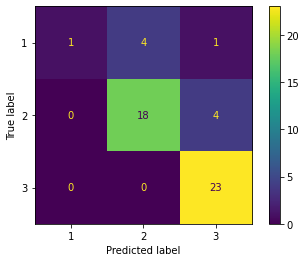

In [99]:
print(f'accuracy on test set: {fitted_model.score(X_test,y_test)}')
print(f"f1 score : {f1_score(y_test, fitted_model.predict(X_test),average='macro')}")
cfd=ConfusionMatrixDisplay.from_estimator(fitted_model,X_test,y_test)

##### Confusion Matrix for All Submissions

accuracy on all submissions: 0.7440476190476191
f1 score : 0.6217903963100211


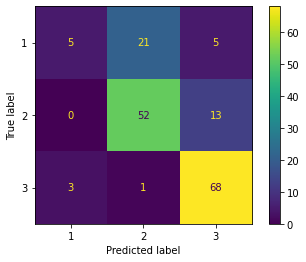

In [100]:
print(f'accuracy on all submissions: {fitted_model.score(sentence_openai_vectors,y)}')
print(f"f1 score : {f1_score(y, predicted_y,average='macro')}")
cfd=ConfusionMatrixDisplay.from_estimator(fitted_model,sentence_openai_vectors,y)

##### Misclassified

In [101]:
for idx,v in enumerate(y):
    if(v!=predicted_y[idx]):
        print(predicted_y[idx],v)
        print(methods[idx])

2 1
{'studentID': 'student085', 'code': "# cell 6 of 14\n\ndef word_count(temp_text):\n    '''Return the number of words'''\n    num_words = 1\n    for x in temp_text: \n        if x == ' ':\n            num_words += 1\n    # num_words: the number of words in the string temp_text\n    return num_words", 'label': '', 'description': 'it is counting the number of words in the string.It is doing this by counting the number of spaces in the string and adding 1 to that count.'}
2 1
{'studentID': 'student033', 'code': '# cell 6 of 14\n\ndef word_count(temp_text):\n    num_words = ""\n    for words in temp_text:\n        if words.lower() == "." or words.lower() == "!" or words.lower() == ";" or words.lower() == ":" or words.lower() == "?" or words.lower() == " ":\n            num_words += words\n    \'\'\'Return the number of words\'\'\'\n    # num_words: the number of words in the string temp_text\n    return len(num_words)', 'label': '', 'description': 'it is counting the number of words in 

#### Unsupervised Hierarchical Clustering

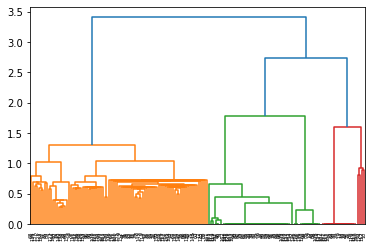

In [102]:
clusterer = Clusterer(sim_mat_sentence)
linkage=clusterer.cluster(clusteringLikage='ward',sigmoid=False)
_=utils.plot_dendrogram(linkage,0,None)

In [103]:
labels=hc.fcluster(linkage,t=3,criterion='maxclust')

In [104]:
clusters={i:[] for i in labels}
for i,m in enumerate(methods):
    clusters[labels[i]].append((m['code'],m['description']))

for k,v in clusters.items():
    print(f"GROUP : {k} SIZE : {len(v)}")
    print()    
    for m in v:
        print('-'+'\n-'.join(nltk.sent_tokenize(m[1])))
        print(m[0])
        print("\n ######")
    print("\n***********************************************")

GROUP : 1 SIZE : 89

-it is counting the number of words in the string.It is doing this by counting the number of spaces in the string and adding 1 to that count.
# cell 6 of 14

def word_count(temp_text):
    '''Return the number of words'''
    num_words = 1
    for x in temp_text: 
        if x == ' ':
            num_words += 1
    # num_words: the number of words in the string temp_text
    return num_words

 ######
-it is counting the number of words in the string.It is doing this by adding 1 to the number of spaces in the string.
# cell 6 of 14

def word_count(temp_text):
    '''Return the number of words'''
    # num_words: the number of words in the string temp_text
    num_words = 1 + (temp_text.count(' '))
    return num_words

 ######
-it is counting the number of words in the string.It is doing this by counting the number of punctuation marks and adding them to a new string.Then it counts the length of that string and returns it as the number of words.
# cell 6 of 14

def 

##### Unsupervised Clustering Comparison to Manual Labels

*********************************

iou:{('0', '2'): 0.5697674418604651, ('2', '4'): 0.3023255813953488, ('3', '3'): 0.2, ('1', '3'): 0.5873015873015873}


accuracy:{('0', '2'): 0.8032786885245902, ('2', '4'): 0.4642857142857143, ('3', '3'): 0.23214285714285715, ('1', '3'): 0.6607142857142857}

rand score: 0.7307527801539777
adjusted rand score: 0.3520604508958028
normalized mutual information: 0.36729793344980866
fowlkes mallows score: 0.5428288646628745
confusion matrix:
    (0,0) - True Negatives. Pair is not clustered together in the predicted and manual clustering.
    (0,1) - False Positives. Pair is clustered together in prediction but not manual clustering.
    (1,0) - False Negatives. Pair is not clustered together in prediction but is clustered together in manual clustering.
    (1,1) - True Positives.  Pair is clustered together in the predicted and manual clustering.



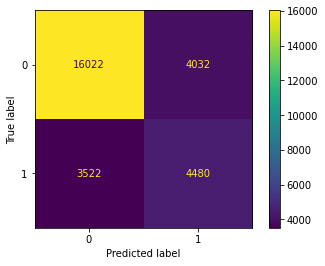

In [83]:
file_path_openai_sentenceVectors='./comp116/116Q2Soln-OPENAI-SentenceSim-4clust-KMeans.json'
cfd=compare(file_path_openai_sentenceVectors,file_path_manual).plot()
label_gmm =[ v['label'] for k,v in load_json(file_path_openai_sentenceVectors).items()]

#### Save to JSON

In [57]:
for i,m in enumerate(methods):
    data[m['studentID']]['label']=str(labels_med[i])
save_json(data,'./comp116/116Q2Soln-OPENAI-SentenceSim-4clust-KMeans')